In [9]:
import pandas as pd
import numpy as np

listings = pd.read_csv("/content/listings 2 reduced.csv",low_memory=False)
reviews = pd.read_csv("/content/reviews 2 reduced.csv",low_memory=False, on_bad_lines='skip', encoding='latin-1')

In [10]:
print(listings.head().to_markdown())
print(reviews.head().to_markdown())

|    |    id | listing_url                        |   scrape_id | last_scraped   | source      | name                                                                      | description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [32]:
listings.info()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            87946 non-null  int64  
 1   listing_url                                   87946 non-null  object 
 2   scrape_id                                     87946 non-null  float64
 3   last_scraped                                  87946 non-null  object 
 4   source                                        87946 non-null  object 
 5   name                                          87946 non-null  object 
 6   description                                   86679 non-null  object 
 7   neighborhood_overview                         47190 non-null  object 
 8   picture_url                                   87943 non-null  object 
 9   host_id                                       87946 non-null 

In [33]:
print(listings.head())
print(reviews.head())

      id                         listing_url     scrape_id last_scraped  \
0  92644  https://www.airbnb.com/rooms/92644  2.023090e+13     9/6/2023   
1  93015  https://www.airbnb.com/rooms/93015  2.023090e+13     9/6/2023   
2  13913  https://www.airbnb.com/rooms/13913  2.023090e+13     9/6/2023   
3  15400  https://www.airbnb.com/rooms/15400  2.023090e+13     9/6/2023   
4  93734  https://www.airbnb.com/rooms/93734  2.023090e+13     9/7/2023   

        source                                               name  \
0  city scrape  Rental unit in Earlsfield · ★4.57 · 1 bedroom ...   
1  city scrape  Rental unit in Hammersmith · ★4.82 · 2 bedroom...   
2  city scrape  Rental unit in Islington · ★4.80 · 1 bedroom ·...   
3  city scrape  Rental unit in London · ★4.80 · 1 bedroom · 1 ...   
4  city scrape  Condo in London · ★4.62 · 1 bedroom · 1 bed · ...   

                                         description  \
0  <b>The space</b><br />Hi everyone! I have 2 ro...   
1  Gorgeous 2 bed grou

In [14]:
listings['price'] = (
    listings['price']
        .astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
        .replace('', np.nan)
        .astype(float)
)

In [23]:
print(listings['price'].head(10).to_frame().to_markdown(index=True))
print(f"New dtype: {listings['price'].dtype}")

|    |   price |
|---:|--------:|
|  0 |      42 |
|  1 |     175 |
|  2 |      79 |
|  3 |     150 |
|  4 |      46 |
|  5 |     476 |
|  6 |     371 |
|  7 |     250 |
|  8 |      75 |
|  9 |      29 |
New dtype: float64


What is the neighborhood in which superhosts have the biggest median price difference with respect to non superhosts? Use the following three columns in the 'listings' dataset to answer this question: 'host_is_superhost', 'neighbourhood_cleansed', and 'price'.

In [24]:
price_analysis = listings.groupby(['neighbourhood_cleansed', 'host_is_superhost'])['price'].median().reset_index()

price_pivot = price_analysis.pivot(index='neighbourhood_cleansed',
                                     columns='host_is_superhost',
                                     values='price')
price_pivot.columns = ['non_superhost', 'superhost']

price_pivot['price_difference'] = price_pivot['superhost'] - price_pivot['non_superhost']

price_pivot_sorted = price_pivot.sort_values('price_difference', ascending=False)

print(price_pivot_sorted.head(10))

                        non_superhost  superhost  price_difference
neighbourhood_cleansed                                            
Westminster                     190.0      238.5              48.5
Kensington and Chelsea          187.0      231.5              44.5
Islington                       102.0      136.5              34.5
Tower Hamlets                    90.0      116.0              26.0
Hackney                          95.0      120.0              25.0
Southwark                       100.0      123.5              23.5
Barnet                           89.0      112.0              23.0
Camden                          131.0      153.0              22.0
Hammersmith and Fulham          125.0      131.0               6.0
Lambeth                          95.0      100.0               5.0


In [25]:
max_diff_neighborhood = price_pivot_sorted.index[0]
max_difference = price_pivot_sorted['price_difference'].iloc[0]

print(f"\nThe neighborhood with the biggest median price difference between superhosts and non-superhosts is:")
print(f"{max_diff_neighborhood}")
print(f"Price difference: ${max_difference:.2f}")
print(f"Superhost median price: ${price_pivot_sorted['superhost'].iloc[0]:.2f}")
print(f"Non-superhost median price: ${price_pivot_sorted['non_superhost'].iloc[0]:.2f}")


The neighborhood with the biggest median price difference between superhosts and non-superhosts is:
Westminster
Price difference: $48.50
Superhost median price: $238.50
Non-superhost median price: $190.00


### Visualize Top 10 Neighborhoods

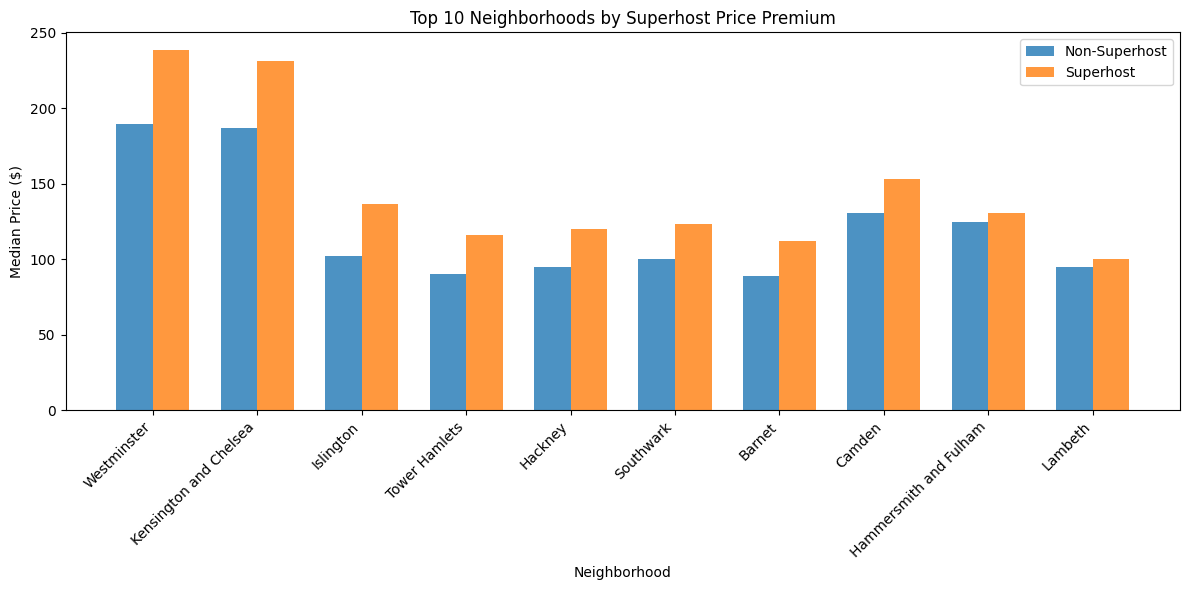

In [26]:
import matplotlib.pyplot as plt

top_10 = price_pivot_sorted.head(10)

plt.figure(figsize=(12, 6))
x = range(len(top_10))
width = 0.35

plt.bar([i - width/2 for i in x], top_10['non_superhost'], width, label='Non-Superhost', alpha=0.8)
plt.bar([i + width/2 for i in x], top_10['superhost'], width, label='Superhost', alpha=0.8)

plt.xlabel('Neighborhood')
plt.ylabel('Median Price ($)')
plt.title('Top 10 Neighborhoods by Superhost Price Premium')
plt.xticks(x, top_10.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Professional vs Non-Professional Hosts

In [27]:
df = listings.groupby('host_id')['neighbourhood_cleansed'].nunique().reset_index()
professional_host = df[df['neighbourhood_cleansed'] > 5]
non_professional_host = df[df['neighbourhood_cleansed'] <= 5]

professional_host_merge = listings.merge(professional_host, on='host_id', how='inner')
non_professional_host_merge = listings.merge(non_professional_host, on='host_id', how='inner')

price_diff = professional_host_merge['price'].mean() - non_professional_host_merge['price'].mean()

print(f"\nAverage price difference between professional and non-professional hosts:")
print(f"${price_diff:.2f}")
print(f"Professional hosts (>5 neighborhoods) average: ${professional_host_merge['price'].mean():.2f}")
print(f"Non-professional hosts (<=5 neighborhoods) average: ${non_professional_host_merge['price'].mean():.2f}")


Average price difference between professional and non-professional hosts:
$285.71
Professional hosts (>5 neighborhoods) average: $443.92
Non-professional hosts (<=5 neighborhoods) average: $158.22


Which of the review scores has the highest correlation to price? Use the following review score columns in the 'listings' dataset: 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'.

In [28]:
review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

corrs = listings[['price'] + review_scores].corr()['price'].sort_values(ascending=False)

print(corrs)

price                          1.000000
review_scores_location         0.025984
review_scores_cleanliness      0.000411
review_scores_rating          -0.001427
review_scores_accuracy        -0.018796
review_scores_checkin         -0.026650
review_scores_communication   -0.030010
review_scores_value           -0.031564
Name: price, dtype: float64


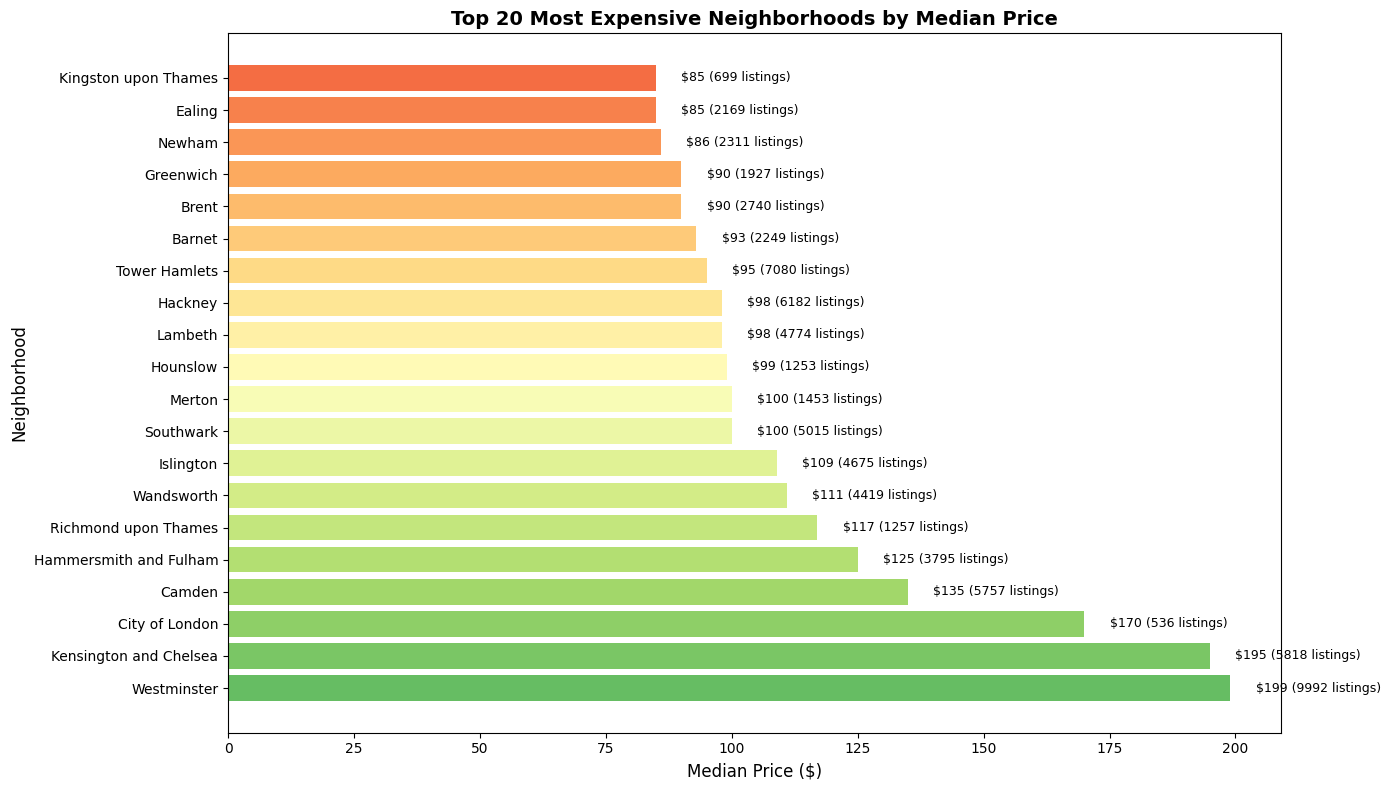

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

neighborhood_prices = listings.groupby('neighbourhood_cleansed').agg({
    'price': ['mean', 'median', 'count']
}).reset_index()

neighborhood_prices.columns = ['neighborhood', 'mean_price', 'median_price', 'listing_count']

# Filter neighborhoods with at least 10 listings
neighborhood_prices = neighborhood_prices[neighborhood_prices['listing_count'] >= 10]

# Sort by median price
neighborhood_prices = neighborhood_prices.sort_values('median_price', ascending=False)

# Plot top 20 most expensive neighborhoods
plt.figure(figsize=(14, 8))
top_20 = neighborhood_prices.head(20)

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_20)))

plt.barh(range(len(top_20)), top_20['median_price'], color=colors)
plt.yticks(range(len(top_20)), top_20['neighborhood'])
plt.xlabel('Median Price ($)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.title('Top 20 Most Expensive Neighborhoods by Median Price', fontsize=14, fontweight='bold')

for i, (price, count) in enumerate(zip(top_20['median_price'], top_20['listing_count'])):
    plt.text(price + 5, i, f'${price:.0f} ({count} listings)',
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2328629666.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


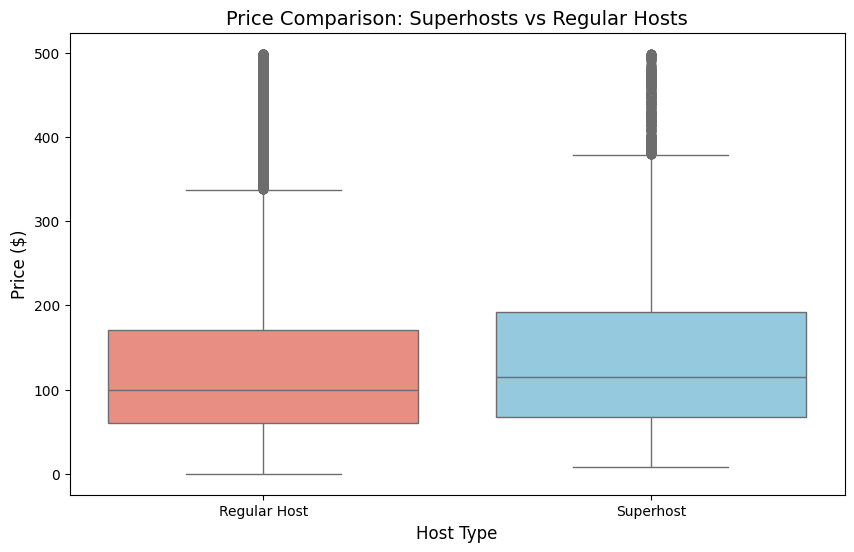

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

price_cutoff = listings['price'].quantile(0.95)
clean_data = listings[listings['price'] <= price_cutoff].copy()

clean_data['host_type'] = clean_data['host_is_superhost'].map({
    0: 'Regular Host',
    1: 'Superhost',
    'f': 'Regular Host',
    't': 'Superhost'
})

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=clean_data,
    x='host_type',
    y='price',
    palette=['salmon', 'skyblue']
)

plt.xlabel('Host Type', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title('Price Comparison: Superhosts vs Regular Hosts', fontsize=14)

plt.show()


# SUMMARY

Airbnb prices vary a lot by neighborhood, and that matters more than host status.
Superhosts generally charge higher prices, especially in popular areas like Westminster and Kensington and Chelsea.
In most neighborhoods, superhosts have a clear premium, but the size of that difference changes from place to place.
Hosts with listings in multiple neighborhoods tend to price higher, suggesting experience plays a role.
The top neighborhoods in the charts show where demand and pricing are strongest.
These areas may offer more solid returns for investors.
Guests can often find better value by comparing regular hosts in the same neighborhood.
Neighborhood is the strongest factor influencing price.
Superhost status typically adds a smaller layer on top.